<img src = "https://s3-us-west-2.amazonaws.com/courses-images-archive-read-only/wp-content/uploads/sites/222/2014/12/20104824/Figure_16_01_02b.jpg" alt = "Encabezado MLDS2 Protecto Final" width = "90%" height = "200">  </img>

# **_ESTADO DE CONDENSADORES EN SISTEMAS DE REFRIGERACIÓN_**
____

<img src = "https://www.bitzer.de/shared_media/html/est-610/Images/jpg/18014398729259403__Web.jpg" alt = "Figura 1" width = "30%%" height = "30%" style="display: block; margin: 0 auto">  </img>
<p style="text-align: center;">Figura 1: Circuito de subenfriamiento de líquido</p>

<div style="text-align: justify">

Los sistemas de refrigeración comercial constantemente tienen actualizaciones en sus circuitos y/o elementos buscando   
mejorar su eficiencia energética; sin embargo, se deja de lado el mantenimiento como factor clave en la reducción del trabajo,
uno de los elementos que requieren una frecuencia precisa es el condensador o gas cooler, ya que no realizar los lavados a tiempo
puede incrmentar la temperatura de condensación de 2°C a 5°C, lo cual representa un incremento entre 6% y 15% de energía; por otro lado,
realizar mantenimientos muy frecuentes aumenta los costos operativos y degrada en el tiempo las láminas de los intercambiadores.

</div>


## 1.ENTENDIMIENTO DEL NEGOCIO ##
---
### _1.A OBJETIVOS DEL NEGOCIO:_ ###

1. Seleccionar y aplicar un modelo de base de datos NoSQL con procesamiento distribuido para administrar a futuro grandes cantidades
de datos.

2. Predecir el intervalo de tiempo adecuado para la realización de mantenimientos en el condensador para un sistema de refrigeración en específico.  



### _1.B METAS DEL PROYECTO:_ ###

<div style="text-align: justify">

1. Hacer un análisis de datos para retirar aquella información que pueda alterar el comportamiento de los modelos de ML.

2. Implementar una base de datos NoSQL para comprender como administrar en un futuro mayores cantidades de datos.

2. Implementar varios modelos de aprendizaje de máquina supervisados con el fin de conocer despues del tiempo **$t_{1}$**  
   de cuánto sería el consumo de energía del sistema para unas condiciones iniciales con subenfriamiento activado.

4. Encontrar los hiperparámetros que generan el mejor comportamiento de cada uno de los modelos aplicados.

5. Seleccionar el modelo que mejor predice el comportamiento de los consumos de energía y sustentarlo a través de
   alguna métrica.

<div/>

## 2. ENTENDIMIENTO DE LOS DATOS: ##
---
### _2.A RECOLECCIÓN DE LOS DATOS_ ###

<div style="text-align: justify">
Se importan las librerias que se usarán en la primera sección del proyecto, los datos se obtienen del supervisor
del sistema de refrigeración del lugar a verificar, este supervisor cuenta con históricos de más de 500 variables
de control, tanto del controlador central, como de controladores remotos y el medidor de energía del sistema, el
cual registra la potencia consumida cada minuto.

<div/>

<img src = "https://assets.danfoss.com/photos/preview/197106/ID107323828811-0201_preview.jpg?w=300&h=300" alt = "Figura 1" width = "25%" height = "25%" style="display: block; margin: 0 auto">  </img>
<p style="text-align: center;">Figura 2: Sistema de supervisión y control</p>

<div style="text-align: justify">

Todos los controladores se conectan al supervisor vía modbus o LON y finalmente, este supervisor permite monitorear
remotamente los datos desde cualquier pc, ya que cuenta con web-server y procolo TCP/IP; para la obtención de los datos
se validaron las credenciales de ingreso, se seleccionaron las variables a descargar, el periodo temporal de revisión y
el periodo de muestreo, estos fueron recibidos desde el cotrol en formato _**.txt**_

<div/>

Se aprovecha la experiencia y conocimiento que se tiene en sistemas de refrigeración y en termodinámica ya se ha hecho una selección inicial de las variables que tienen una correlación importante con el aumento en consumo de energía del sistema por cuenta de falta de mantenimiento en el condensador o gas cooler.

In [7]:
#TEST_CELL
!pip install dask[complete] h5py dask-ml

Defaulting to user installation because normal site-packages is not writeable


In [8]:
!pip install pandas==2.2.2

Defaulting to user installation because normal site-packages is not writeable


In [9]:
import sklearn
from sklearn.datasets import *
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import dask.array as da
import dask.dataframe as dd

pd.__version__

'2.2.2'

### _2.B DESCRIPCIÓN DE LOS DATOS_ ###

<div style="text-align: justify">

Se comprueba que el dataset tiene el tamaño esperado y se han leído las variables con el tipo esperado, a continuación
la descripción y justificación de cada una de las características seleccionadas:

-_**Time:**_ Fecha y hora en la que se toma el dato, este tipo de sistemas tienen una configuración que relaja los paramétros
de control durante la noche.

-_**Temperatura Gas Cooler (Sgc):**_ Temperatura a la que sale el refrigerante del Gas Cooler, es una variable muy importante que determina en muchos casos que tan buena es la trasnferencia de calor en el intercambiador.

-_**Pres Descarga (Pgc):**_ Presión a la que descargan los compresores, siempre se desean valores bajos pero están restringidos por la
temperatura ambiente y las presiones de succión, su aumento impacta directamente en el consumo de energía.
     

-_**Capacidad Asp. BT:**_ Porcentaje de compresores prendidos para el área de congelación.  
  
-_**Capacidad Asp. MT:**_ Porcentaje de compresores prendidos para el área de refrigeración.  
  
-_**TempExterior (SC3):**_ Temperatura ambiente, de gran importancia pues uno de los elementos más importantes del sistema es un
intercambiador de calor de fluido refrigerante con aire ambiente, bajas temperaturas ambiente mejoran la transferencia y mejoran la
eficiencia del sistema.

-_**Gas Cooler demand:**_ Potencia instántanea leída por el medidor de energía en el Gas Cooler.  

-_**Válvula alta presión (Vhp):**_ Válvula cuya apertura depende de la presión deseada en el intercambiador, puede interferir en la eficiencia del mismo al variar la presión interna, y por tanto, las condiciones termodinámicas del equipo.
  
-_**Rack demand:**_ Potencia instántanea leída por el medidor de energía en el Rack.


</div>

In [11]:
dask_df = dd.read_csv("~/Downloads/SANTA BARBARA 010624.csv", delimiter = ',')
#print(df.head)
#print(df.iloc[0:10,:])
print(dask_df.shape)
print(dask_df.dtypes)


(<dask_expr.expr.Scalar: expr=ReadCSV(e1cf493).size() // 5, dtype=int32>, 5)
CARULLA SANTA BARBAR  Sat Jun 01 2024 1550.csv    string[pyarrow]
Santa Barbara test2                               string[pyarrow]
CARULLA SANTA BARBAR undefined                    string[pyarrow]
1699376400000                                     string[pyarrow]
2Min                                                      float64
dtype: object


### _2.C EXPLORACIÓN DE LOS DATOS_ ###

1. Se toma una muestra de los datos para comprobar que sean correctos, se encuentran indices multiples, se inicia a trabajar para garantizar los nombres correctos de columnas y dejar un solo índice.

In [12]:
dask_df.compute()


CARULLA SANTA BARBAR  Sat Jun 01 2024 1550.csv  \
Name                    Carulla STA BARB:  Sgc ctrl. Carulla STA BARB:  Pgc Carulla STA BARB:  Cond. capacity Carulla STA BARB:  C1 MT capacity Carulla STA BARB:  C2 MT capacity Carulla STA BARB:  C3 MT capacity Carulla STA BARB:  C4 MT capacity Carulla STA BARB:  C1 LT capacity Carulla STA BARB:  Sc3                      Carulla STA BARB:  Vhp OD   
Units                   degc                         bar                    percent                           percent                           percent                           percent                           percent                           percent                           degc                                                          percent   
Digital                 false                        false                  false                             false                             false                             false                             false                             false                             false                                                           false   
Sample Rate             2Min                         2Min                   2Min                              2Min                              2Min                              2Min                              2Min                              2Min                              2Min                                                             2Min   
11:59:00 AM  11/07/2023 22.22                        60.42                  100                               100                               0                                 0                                 100                               66                                16.72                                                            47.7   
...                                                                                                                                                                                                                                                                                                                                                       ...   
11:50:19 AM  05/31/2024 26.78                        68.18                  100                               100                               0                                 100                               0                                 96                                22.11                                                            51.8   
11:52:19 AM  05/31/2024 27.89                        68.18                  100                               85                                0                                 100                               0                                 85                                22.11                                                            51.8   
11:54:19 AM  05/31/2024 28.39                        68.18                  100                               50                                0                                 100                               0                                 65                                22.11                                                            51.8   
11:56:19 AM  05/31/2024 28.17                        68.18                  100                               50                                0                                 100                               0                                 75                                22.11                                                            51.8   
11:58:19 AM  05/31/2024 27.89                        68.18                  100                               78                                0                                 0                                 0                                 88                                22.11                                                            51.8   

                                                                  

In [13]:
dask_df = dask_df.reset_index()



In [14]:
dask_df.compute()

level_0                       level_1  \
0                          Name  Carulla STA BARB:  Sgc ctrl.   
1                         Units                          degc   
2                       Digital                         false   
3                   Sample Rate                          2Min   
4       11:59:00 AM  11/07/2023                         22.22   
...                         ...                           ...   
147818  11:50:19 AM  05/31/2024                         26.78   
147819  11:52:19 AM  05/31/2024                         27.89   
147820  11:54:19 AM  05/31/2024                         28.39   
147821  11:56:19 AM  05/31/2024                         28.17   
147822  11:58:19 AM  05/31/2024                         27.89   

                       level_2                            level_3  \
0       Carulla STA BARB:  Pgc  Carulla STA BARB:  Cond. capacity   
1                          bar                            percent   
2                        false                              false   
3                         2Min                               2Min   
4                        60.42                                100   
...                        ...                                ...   
147818                   68.18                                100   
147819                   68.18                                100   
147820                   68.18                                100   
147821                   68.18                                100   
147822                   68.18                                100   

                                  level_4                            level_5  \
0       Carulla STA BARB:  C1 MT capacity  Carulla STA BARB:  C2 MT capacity   
1                                 percent                            percent   
2                                   false                              false   
3                                    2Min                               2Min   
4                                     100                                  0   
...                                   ...                                ...   
147818                                100                                  0   
147819                                 85                                  0   
147820                                 50                                  0   
147821                                 50                                  0   
147822                                 78                                  0   

                                  level_6                            level_7  \
0       Carulla STA BARB:  C3 MT capacity  Carulla STA BARB:  C4 MT capacity   
1                                 percent                            percent   
2                                   false                              false   
3                                    2Min                               2Min   
4                                       0                                100   
...                                   ...                                ...   
147818                                100                                  0   
147819                                100                                  0   
147820                                100                                  0   
147821                                100                                  0   
147822                                  0                                  0   

                                  level_8                 level_9  \
0       Carulla STA BARB:  C1 LT capacity  Carulla STA BARB:  Sc3   
1                                 percent                    degc   
2                                   false                   false   
3                                    2Min                    2Min   
4                                      66                   16.72   
...                                   ...                     ...   
147818   

In [15]:
header = dask_df.head(1).iloc[0].tolist()
#dask_df = dask_df.loc[dask_df.index > 0, :]
dask_df.columns = header
dask_df = dask_df.iloc[:,:-1]

2. Se cambian algunos nombres de columnas para facilitar la visualización.

In [16]:
dask_df = dask_df.rename(columns = {"Name" : "Fecha"})
dask_df = dask_df
new_column_names = {col: col.replace('Carulla STA BARB:  ', '') for col in dask_df.columns}
dask_df = dask_df.rename(columns = new_column_names)
print(dask_df.columns)

Index(['Fecha', 'Sgc ctrl.', 'Pgc', 'Cond. capacity', 'C1 MT capacity',
       'C2 MT capacity', 'C3 MT capacity', 'C4 MT capacity', 'C1 LT capacity',
       'Sc3', 'Vhp OD', 'C2 LT capacity', 'Medidor rack:  Demand kW',
       'Medidor Gas Cooler:  Demand kW'],
      dtype='object')


3. Se eliminan todas las filas que tienen en alguno de sus campos un string de tipo no númerico, esto con el fin de garantizar que solo existirán variables numéricas, además de la fecha y la hora.

In [17]:
def filter_non_numeric_rows(df_p):
    return df_p[df_p.apply(lambda row: all(str(val).replace('.', '').isdigit() if col not in ['Fecha'] else True for col, val in row.items()), axis=1)]


# Apply the custom function to each partition of the Dask DataFrame
#columns_to_select = [col for col in dask_df.columns if col != 'Fecha']
#dask_df_part = dask_df[columns_to_select]
dask_df = dask_df.map_partitions(filter_non_numeric_rows)

In [18]:
dask_df = dask_df.reset_index(drop=True)

4. Despues de reiniciar el indice, se convierten los datos de fecha y hora a objetos de tipo tiempo.

In [19]:

#datetime_format = "%I:%M:%S %p  %m/%d/%Y"

dask_df['Fecha'] = dd.to_datetime(dask_df['Fecha'], format = 'mixed')

# Extract the time component from the datetime values
dask_df['Hora'] = dd.to_datetime(dask_df['Fecha'].dt.time, format = '%H:%M:%S')

In [20]:
dask_df.compute()

Fecha Sgc ctrl.    Pgc Cond. capacity C1 MT capacity  \
0      2023-11-07 11:59:00     22.22  60.42            100            100   
1      2023-11-07 12:01:00     22.22  60.42            100            100   
2      2023-11-07 12:03:00     22.22  60.42            100            100   
3      2023-11-07 12:05:00     22.22  60.42            100            100   
4      2023-11-07 12:07:00     22.22  60.42            100            100   
...                    ...       ...    ...            ...            ...   
142784 2024-05-31 11:50:19     26.78  68.18            100            100   
142785 2024-05-31 11:52:19     27.89  68.18            100             85   
142786 2024-05-31 11:54:19     28.39  68.18            100             50   
142787 2024-05-31 11:56:19     28.17  68.18            100             50   
142788 2024-05-31 11:58:19     27.89  68.18            100             78   

       C2 MT capacity C3 MT capacity C4 MT capacity C1 LT capacity    Sc3  \
0                   0              0            100             66  16.72   
1                   0              0            100             66  16.72   
2                   0              0            100             66  16.72   
3                   0              0            100             66  16.72   
4                   0              0            100             66  16.72   
...               ...            ...            ...            ...    ...   
142784              0            100              0             96  22.11   
142785              0            100              0             85  22.11   
142786              0            100              0             65  22.11   
142787              0            100              0             75  22.11   
142788              0              0              0             88  22.11   

       Vhp OD C2 LT capacity Medidor rack:  Demand kW  \
0        47.7            100                     37.4   
1        47.7            100                     37.4   
2        47.7            100                     37.4   
3        47.7            100                     37.4   
4        47.7            100                     37.4   
...       ...            ...                      ...   
142784   51.8            100                     28.1   
142785   51.8            100                     28.1   
142786   51.8            100                       32   
142787   51.8            100                       32   
142788   51.8            100                       32   

       Medidor Gas Cooler:  Demand kW                Hora  
0                                 2.4 1900-01-01 11:59:00  
1                                 2.4 1900-01-01 12:01:00  
2                                 2.4 1900-01-01 12:03:00  
3                                 2.4 1900-01-01 12:05:00  
4                                 2.4 1900-01-01 12:07:00  
...                               ...                 ...  
142784                            2.4 1900-01-01 11:50:19  
142785                            2.4 1900-01-01 11:52:19  
142786                            2.4 1900-01-01 11:54:19  
142787                            2.4 1900-01-01 11:56:19  
142788                            2.4 1900-01-01 11:58:19  

[142789 rows x 15 columns]

5. Se convierten todos los string númericos de las columnas que lo permiten a valores tipo float.

In [254]:
exclude_columns = ['Fecha', 'Hora']  # Replace with your column names
numeric_string_columns = [col for col in dask_df.columns if col not in exclude_columns]


# Cast the columns containing numeric strings to numeric data types
for col in numeric_string_columns:
    dask_df[col] = dask_df[col].astype(float)

6. Se seleccionan todos los compresores de media y baja temperatura y se aplica un promedio a sus capacidades para obtener las capacidades del Rack en MT y BT.

In [255]:
MT_columns = dask_df.loc[:, dask_df.columns.str.contains('MT capacity')]
LT_columns = dask_df.loc[:, dask_df.columns.str.contains('LT capacity')]

# Compute the mean across the rows for the selected columns
dask_df['MT capacity'] = MT_columns.mean(axis=1)
dask_df['LT capacity'] = LT_columns.mean(axis=1)

7. Se eliminan las columnas de capacidades de compresores, ya que los valores totales ya tienen en cuenta estos datos.

In [256]:
print(MT_columns.columns, LT_columns.columns)
columns_to_drop = set(MT_columns.columns) | set(LT_columns.columns)
print(columns_to_drop)
test_dask = dask_df.drop(columns = columns_to_drop)



Index(['C1 MT capacity', 'C2 MT capacity', 'C3 MT capacity', 'C4 MT capacity'], dtype='object') Index(['C1 LT capacity', 'C2 LT capacity'], dtype='object')
{'C2 LT capacity', 'C1 MT capacity', 'C2 MT capacity', 'C4 MT capacity', 'C1 LT capacity', 'C3 MT capacity'}


In [257]:
test_dask.info()
test_dask.compute()

<class 'dask.dataframe.core.DataFrame'>
Columns: 11 entries, Fecha to LT capacity
dtypes: datetime64[ns](2), float64(9)

Fecha  Sgc ctrl.    Pgc  Cond. capacity    Sc3  Vhp OD  \
0      2023-11-07 11:59:00      22.22  60.42           100.0  16.72    47.7   
1      2023-11-07 12:01:00      22.22  60.42           100.0  16.72    47.7   
2      2023-11-07 12:03:00      22.22  60.42           100.0  16.72    47.7   
3      2023-11-07 12:05:00      22.22  60.42           100.0  16.72    47.7   
4      2023-11-07 12:07:00      22.22  60.42           100.0  16.72    47.7   
...                    ...        ...    ...             ...    ...     ...   
142784 2024-05-31 11:50:19      26.78  68.18           100.0  22.11    51.8   
142785 2024-05-31 11:52:19      27.89  68.18           100.0  22.11    51.8   
142786 2024-05-31 11:54:19      28.39  68.18           100.0  22.11    51.8   
142787 2024-05-31 11:56:19      28.17  68.18           100.0  22.11    51.8   
142788 2024-05-31 11:58:19      27.89  68.18           100.0  22.11    51.8   

        Medidor rack:  Demand kW  Medidor Gas Cooler:  Demand kW  \
0                           37.4                             2.4   
1                           37.4                             2.4   
2                           37.4                             2.4   
3                           37.4                             2.4   
4                           37.4                             2.4   
...                          ...                             ...   
142784                      28.1                             2.4   
142785                      28.1                             2.4   
142786                      32.0                             2.4   
142787                      32.0                             2.4   
142788                      32.0                             2.4   

                      Hora  MT capacity  LT capacity  
0      1900-01-01 11:59:00        50.00         83.0  
1      1900-01-01 12:01:00        50.00         83.0  
2      1900-01-01 12:03:00        50.00         83.0  
3      1900-01-01 12:05:00        50.00         83.0  
4      1900-01-01 12:07:00        50.00         83.0  
...                    ...          ...          ...  
142784 1900-01-01 11:50:19        50.00         98.0  
142785 1900-01-01 11:52:19        46.25         92.5  
142786 1900-01-01 11:54:19        37.50         82.5  
142787 1900-01-01 11:56:19        37.50         87.5  
142788 1900-01-01 11:58:19        19.50         94.0  

[142789 rows x 11 columns]

### _2.D VERIFICACIÓN DE LA CALIDAD DE LOS DATOS_ ###

2. Se obtienen los principales valores estadísticos del conjunto de datos, allí ya se encuentran valores anormales como: lineas perfectamente rectas en comportamientos que por la naturaleza de los sistemas no corresponden con la realidad.

In [258]:
desc = test_dask.describe(include = 'all')
desc.compute()

Fecha      Sgc ctrl.            Pgc  Cond. capacity  \
count               142789  142789.000000  142789.000000   142789.000000   
min    2023-11-07 11:59:00       0.000000      45.190000        0.000000   
25%    2023-12-27 04:06:19      18.940000      59.460000       88.000000   
50%    2024-02-15 21:40:19      22.220000      60.450000      100.000000   
75%    2024-04-07 10:24:19      24.780000      63.390000      100.000000   
max    2024-05-31 11:58:19      33.280000      82.460000      100.000000   
mean                  <NA>      21.767882      61.919695       80.179180   
std                   <NA>       4.446554       3.982046       37.160584   

                 Sc3         Vhp OD  Medidor rack:  Demand kW  \
count  142789.000000  142789.000000             142789.000000   
min         9.110000       0.000000                  0.000000   
25%        15.670000      35.200000                 27.600000   
50%        16.720000      46.100000                 37.400000   
75%        19.500000      49.700000                 46.400000   
max        29.890000      65.600000                 65.800000   
mean       17.703870      42.604710                 37.477159   
std         3.093599      10.555774                 10.538760   

       Medidor Gas Cooler:  Demand kW                 Hora    MT capacity  \
count                   142789.000000               142789  142789.000000   
min                          0.700000  1900-01-01 00:00:19       0.000000   
25%                          2.400000  1900-01-01 06:01:19      37.500000   
50%                          2.400000  1900-01-01 12:01:19      50.000000   
75%                          2.400000  1900-01-01 17:59:19      62.500000   
max                          6.900000  1900-01-01 23:59:19     100.000000   
mean                         2.402710                 <NA>      48.576147   
std                          0.060098                 <NA>      17.404726   

         LT capacity  
count  142789.000000  
min         0.000000  
25%        50.000000  
50%        79.500000  
75%        86.500000  
max       100.000000  
mean       72.639079  
std        22.907164

In [263]:
df = test_dask.compute()

## 3. PREPARACIÓN DE LOS DATOS ##

### _3.A SELECCIÓN DE DATOS FINALES_ ###

3. Se han generado todas las funciones de preparación de datos previamente, solo queda eliminar valores repetidos con una frecuencia muy alta.

Se procede a gráficar cada una de las columnas para entender mejor el porqué de ciertos valores atípicos y analizar visualmente
sectores sin datos o con datos anormales.

In [266]:
float_columns = df.select_dtypes(include ='float').columns
df[float_columns] = df[float_columns].round(1)
print(df.sample(5))

                     Fecha  Sgc ctrl.   Pgc  Cond. capacity   Sc3  Vhp OD  \
55800  2024-01-24 10:53:19       29.3  67.5           100.0  24.8    44.1   
108338 2024-04-09 04:08:19       13.0  64.2             0.0  12.8    27.4   
71856  2024-02-16 14:49:19       27.5  58.6           100.0  20.7    52.6   
43770  2024-01-07 09:51:19       24.4  70.0           100.0  19.6    57.9   
57417  2024-01-26 17:04:19       25.6  60.6           100.0  19.2    52.2   

        Medidor rack:  Demand kW  Medidor Gas Cooler:  Demand kW  \
55800                       25.6                             2.5   
108338                      28.6                             2.4   
71856                       50.4                             2.4   
43770                       23.8                             2.4   
57417                       45.2                             2.3   

                      Hora  MT capacity  LT capacity  
55800  1900-01-01 10:53:19         50.0         87.0  
108338 1900-01-01 

In [267]:
def create_plot(dataframe):

    fig, axs = plt.subplots(nrows = dataframe.shape[1] , ncols = 1, figsize = (15, 100))
    i = 0

    for ax in axs:
        col = dataframe.iloc[:,i]
        #ax.plot(dataframe.index, col )
        ax.plot(dataframe.loc[:, 'Fecha'], col)
        ax.set_xlabel('Fecha')
        ax.set_ylabel(col.name)
        ax.set_title('Plot using Matplotlib')
        ax.tick_params(axis='x', rotation=90)

        # X-axis tick formatter and interval configuration
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

        i = i + 1
        # Y-axis tick formatter and interval configuration
    # ax.yaxis.set_major_formatter('{:.1f}')  # Example: Format to 2 decimal places
    # ax.yaxis.set_major_locator(plt.MaxNLocator(10))  # Example: Set maximum of 5 ticks
    fig.subplots_adjust(hspace = 0.5)

    return fig




In [268]:
fig = create_plot(df)

# You can save the plot to a file if desired
#fig.savefig('plot.png')

# Show the plot
plt.show()

In [269]:
fig1, ax1 = plt.subplots(figsize = (20,10))
plt.setp(ax1.get_xticklabels(), rotation = 45)

ax1.plot(df['Fecha'], df['Sc3'] )
ax1.plot(df['Fecha'], df['Sgc ctrl.'] )
ax1.set_xlabel('Time')
ax1.set_ylabel('Data')
#ax1.set_title('Plot using Matplotlib')
#ax1.tick_params(axis='x', rotation=90)

# X-axis tick formatter and interval configuration
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))


In [ ]:

#plt.setp(ax1.get_xticklabels(), rotation = 'vertical' )
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
#Create the second y-axis
#ax2 = ax1.twinx()
#Plot the second column on the right y-axis
#ax2.set_ylabel('Temp Sensor', color='blue')
# Display the plot


#fig, ax1 = df.plot(subplots = True, figsize = (10, 15))
#fig, ax1 = plt.subplots( figsize = (10, 15), subplots = True )


#df.plot.line(ax = ax1)
# Plot the first column on the left y-axis
#ax1.plot(1, 1)
#ax1.plot(df['Sensor Intercam (SI)'], color='blue')

6. Se renombran cada una de las columnas para mejor lectura y manejo de la información, y se elimina la columna _Energy_, ya que
ha cumplido su función al comprobarse que los máximos de energy son coincidentes con los máximos de _Power_

### _3.B LIMPIEZA DE LOS DATOS_ ###

7. Se decide eliminar todos los valores de presiones y/o temperaturas iguales o menores a $0$, ya que no tienen sentido
en este tipo de sistema, se opta por la eliminación en lugar de la imputación debido a que son muy pocos datos faltantes y ya
hay una buena cantidad de datos que representan completamente el comportamiento periodico de estos.

In [278]:
df = df.drop( df[ (df['Sgc ctrl.'] <= 5) | (df['Pgc'] <= 50) | (df['Medidor rack:  Demand kW'] <= 10)
                | (df['MT capacity'] <= 10) ].index )
"""df3 = df.drop( df[ df['Sensor Intercam (SI)'] <= 0 ].index )
df3 = df.drop( df[ df['Sensor Intercam (SI)'] <= 0 ].index ) """
#df3 = df[ (df['Tamb'] > 0) | (df['Tsc'] > 0) | (df['Ps_BT'] > 0) | (df['Ps_MT']  > 0) ]
print(df.shape)

exclude_columns = ['Fecha', 'Hora']  # Replace with your column names
other_columns = [col for col in df.columns if col not in exclude_columns]

df = df.drop_duplicates(other_columns)



print(df.head(10))




(127351, 11)
                    Fecha  Sgc ctrl.   Pgc  Cond. capacity   Sc3  Vhp OD  \
0     2023-11-07 11:59:00       22.2  60.4           100.0  16.7    47.7   
15301 2023-11-28 18:01:00       22.8  61.8           100.0  16.7    47.7   
15302 2023-11-28 18:03:00       23.3  61.3           100.0  16.8    49.6   
15303 2023-11-28 18:05:00       23.6  60.9           100.0  16.8    53.4   
15304 2023-11-28 18:07:00       23.3  58.8           100.0  16.7    53.1   
15305 2023-11-28 18:09:00       22.2  58.5           100.0  16.8    50.1   
15306 2023-11-28 18:11:00       21.7  59.1           100.0  16.9    48.1   
15307 2023-11-28 18:13:00       21.8  59.0           100.0  16.7    44.3   
15308 2023-11-28 18:15:00       22.1  59.5           100.0  16.7    46.3   
15309 2023-11-28 18:17:00       22.3  60.2           100.0  16.6    46.4   

       Medidor rack:  Demand kW  Medidor Gas Cooler:  Demand kW  \
0                          37.4                             2.4   
15301           

8. Se grafica nuevamente el conjunto de datos luego de su depuración.

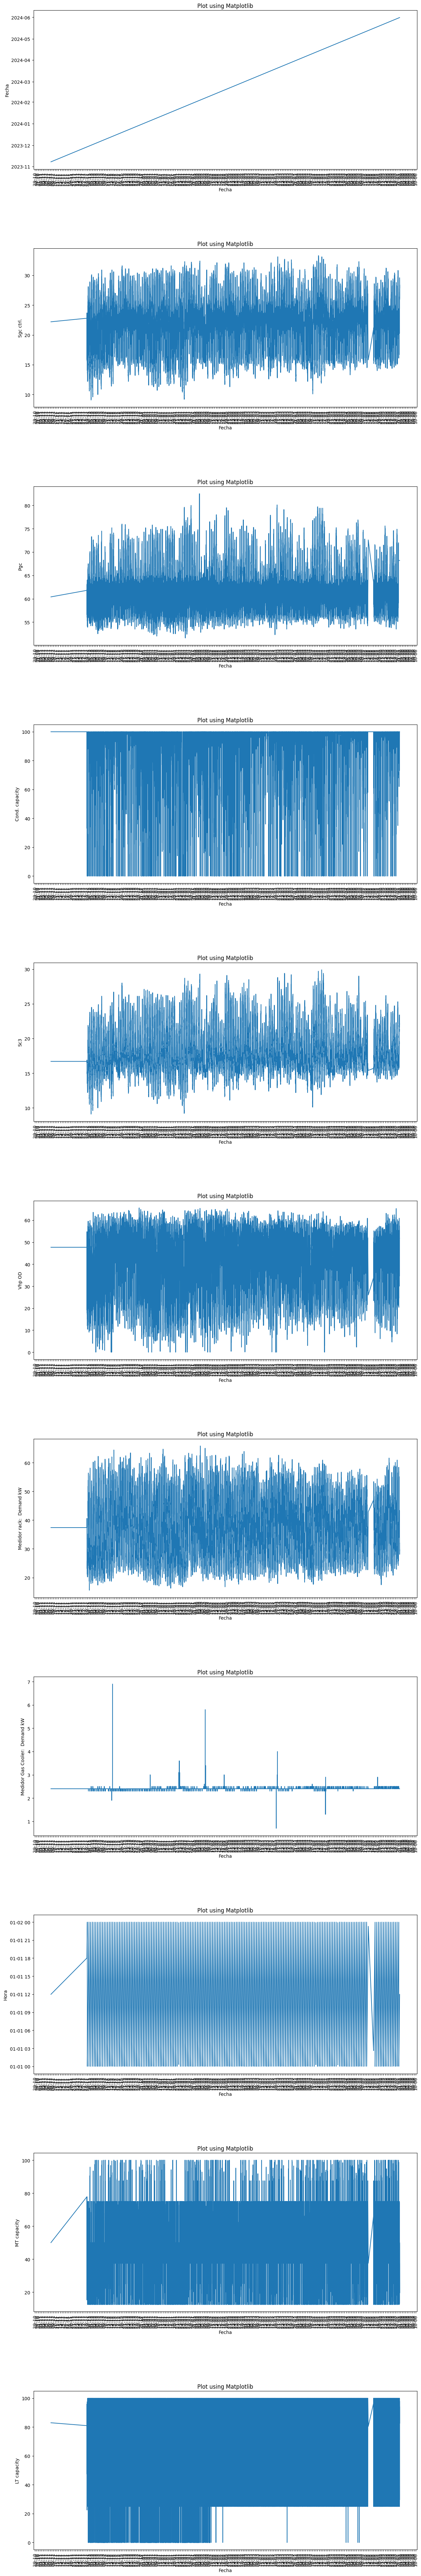

In [279]:
#df.plot.line(subplots = True, figsize = (10, 15))
fig2 = create_plot(df)

# You can save the plot to a file if desired
#fig.savefig('plot.png')

# Show the plot
plt.show()

9. Se verifica que ahora los estadísticos son coherentes y representan de manera acertada al conjunto de datos.

In [280]:
df.drop( df[ (df['Fecha'] >= "2023-11-07 11:59:00") &
        (df['Fecha'] < "2023-11-15 00:00:00") ].index, inplace = True )


df = df.reset_index( drop = True)

In [281]:
print(df.describe())

                               Fecha      Sgc ctrl.            Pgc  \
count                         127350  127350.000000  127350.000000   
mean   2024-02-27 09:10:41.929713408      21.714151      62.099951   
min              2023-11-28 18:01:00       9.100000      51.600000   
25%              2024-01-12 03:25:49      17.800000      59.300000   
50%              2024-02-26 22:02:19      22.300000      60.900000   
75%              2024-04-12 22:26:49      25.100000      63.900000   
max              2024-05-31 11:58:19      33.300000      82.500000   
std                              NaN       4.702088       4.177683   

       Cond. capacity            Sc3         Vhp OD  Medidor rack:  Demand kW  \
count   127350.000000  127350.000000  127350.000000             127350.000000   
mean        77.813404      17.821584      41.992642                 37.525128   
min          0.000000       9.100000       0.000000                 15.600000   
25%         74.000000      15.500000      34.

In [282]:
#df.plot.line(subplots = True, figsize = (10, 15))
fig3 = create_plot(df)

# You can save the plot to a file if desired
#fig.savefig('plot.png')

# Show the plot
plt.show()

10. Se generan los histogramas para verificar si existe una distribución normal para cada una de las variables, analizar
gráficamente la dispersión de los datos en cada caso y comprobar el skew.

In [283]:
df.hist( figsize = (20, 18) )

array([[<Axes: title={'center': 'Fecha'}>,
        <Axes: title={'center': 'Sgc ctrl.'}>,
        <Axes: title={'center': 'Pgc'}>],
       [<Axes: title={'center': 'Cond. capacity'}>,
        <Axes: title={'center': 'Sc3'}>,
        <Axes: title={'center': 'Vhp OD'}>],
       [<Axes: title={'center': 'Medidor rack:  Demand kW'}>,
        <Axes: title={'center': 'Medidor Gas Cooler:  Demand kW'}>,
        <Axes: title={'center': 'Hora'}>],
       [<Axes: title={'center': 'MT capacity'}>,
        <Axes: title={'center': 'LT capacity'}>, <Axes: >]], dtype=object)

11. Las cajas de Bigote permiten observar problemas principalmente en el control de la presión de BT (Congelación) y la presión de
descarga $P_{d}$, así como se evidencia que para la potencia hay una dispersión mas alta en los datos del tercer cuartil que en los del
segundo, lo cual comprueba el efecto de ajustes previos al sistema en busca de mantenerlo en los valores más bajos de potencia.

<Axes: >

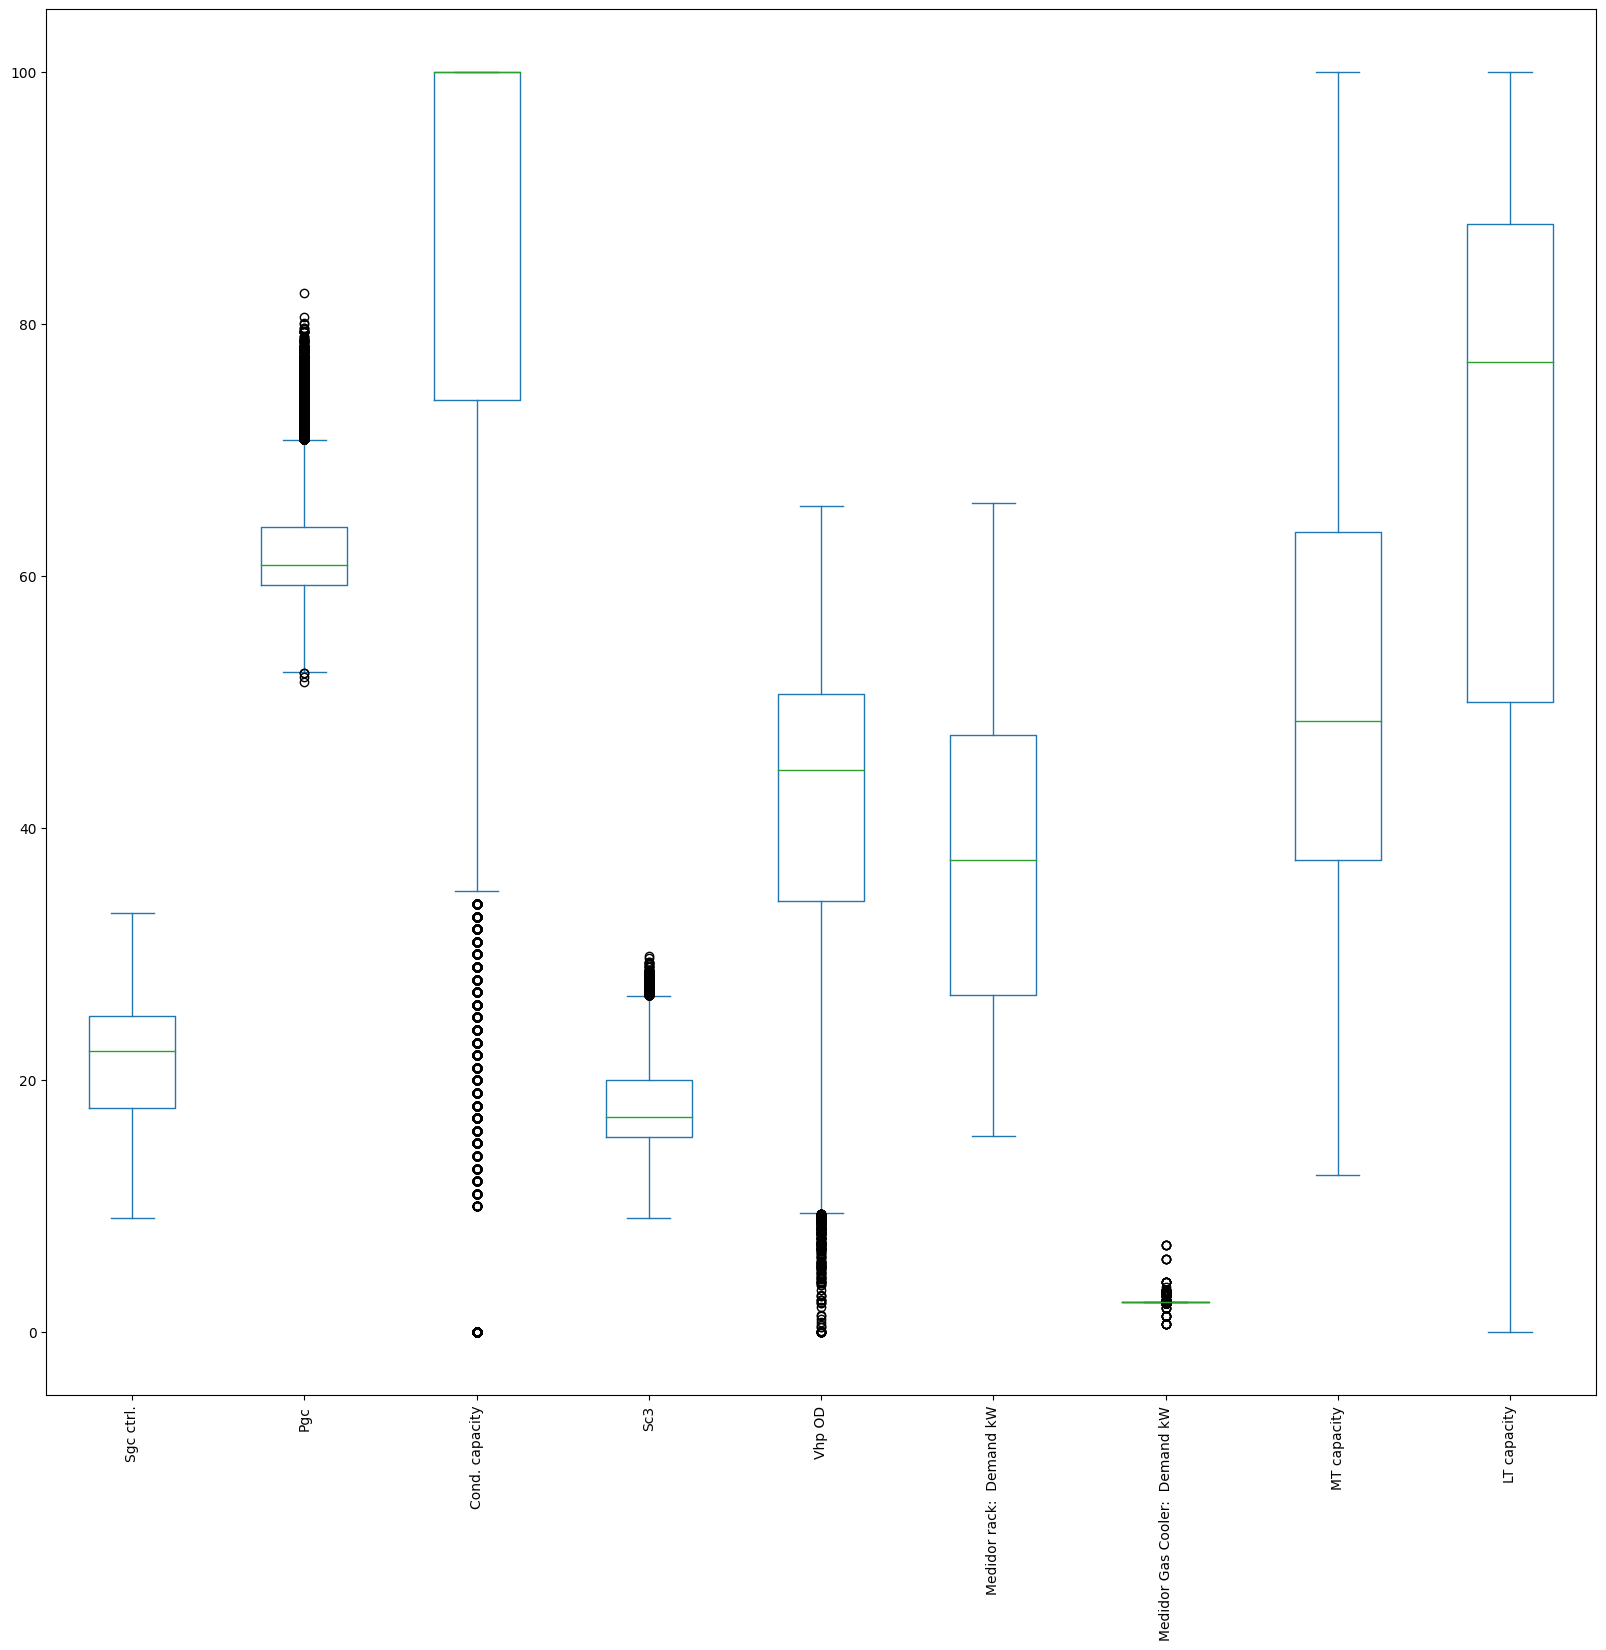

In [284]:
df.plot.box( figsize = (20, 18), rot = 90 )

12. Se comprueba que el sistema logra mantener cierta estabilidad en dos de potencia sin importar la variación de temperatura.

<Axes: xlabel='Sc3', ylabel='Sgc ctrl.'>

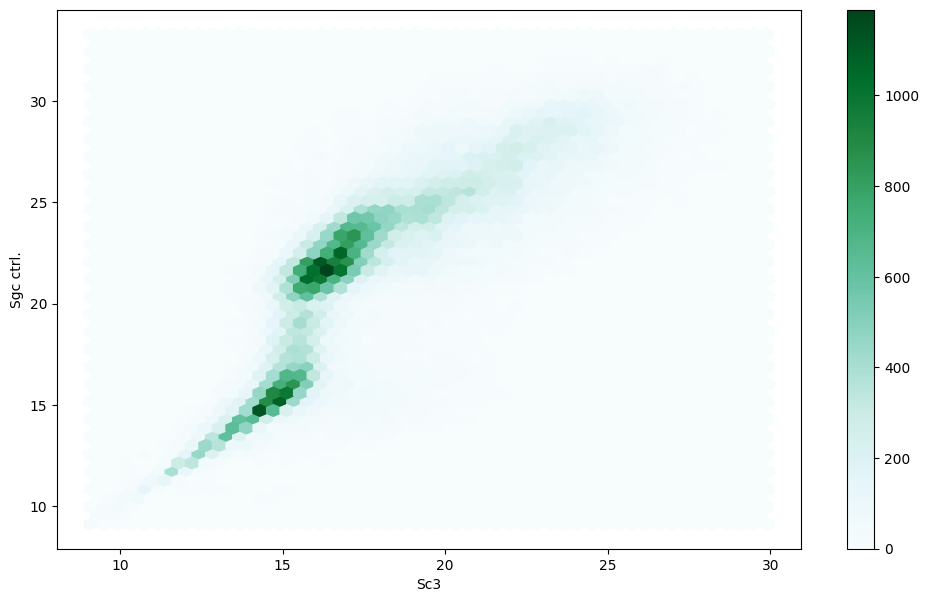

In [285]:
df.plot.hexbin('Sc3', 'Sgc ctrl.', figsize = (12, 7), gridsize = 50 )

13. Se demuestra el efecto de la presión de descarga sobre la temperatura de salida del intercambiador, aún con este elemento de mejora de subcooling, este no logra ser controlado cuando la presión de descarga aumenta.

<Axes: xlabel='Medidor rack:  Demand kW', ylabel='Sgc ctrl.'>

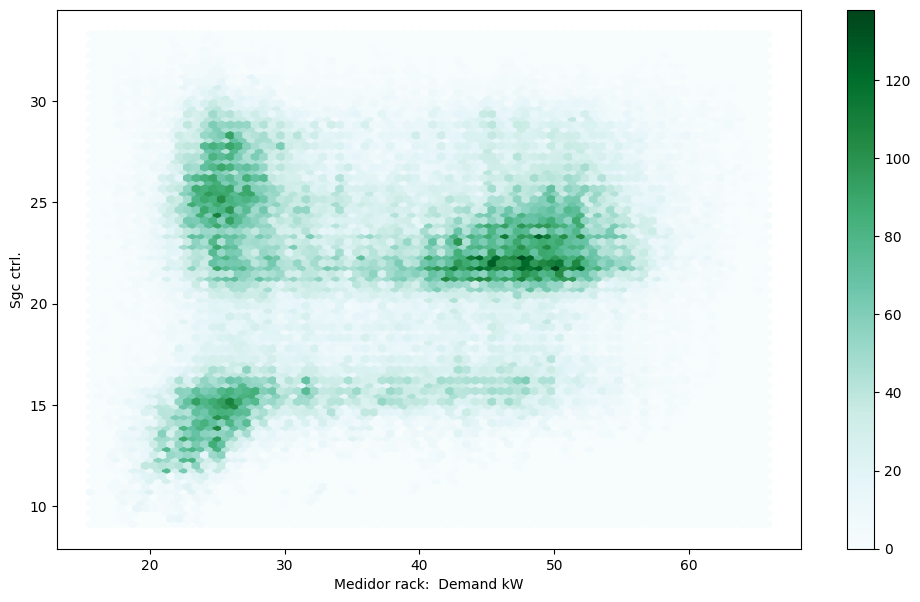

In [315]:
df.plot.hexbin('Medidor rack:  Demand kW', 'Sgc ctrl.', figsize = (12, 7), gridsize = 80 )

In [288]:
df.skew(axis = 0, skipna = True, numeric_only = True)

Sgc ctrl.                         -0.303799
Pgc                                1.096836
Cond. capacity                    -1.366139
Sc3                                0.609705
Vhp OD                            -0.578567
Medidor rack:  Demand kW           0.118625
Medidor Gas Cooler:  Demand kW    20.931084
MT capacity                       -0.131365
LT capacity                       -0.860977
dtype: float64

### _3.C PARTICIÓN DE LOS DATOS_ ###

## 4. MODELAMIENTO: ##

### _4.A SELECCIÓN DEL MODELO APROPIADO_ ###

1. Se divide el conjunto de datos en X, y.

In [291]:
#X = df.loc[:, df.columns != ['Power', 'Time'] ]
X = df[ df.columns.difference(['Sgc ctrl.', 'Hora']) ]
y = df.loc[:, 'Sgc ctrl.']
print(X.shape, y.shape)
print(X.head(5))

(127350, 9) (127350,)
   Cond. capacity               Fecha  LT capacity  MT capacity  \
0           100.0 2023-11-28 18:01:00         81.0         77.8   
1           100.0 2023-11-28 18:03:00         86.5         65.2   
2           100.0 2023-11-28 18:05:00         88.0         65.2   
3           100.0 2023-11-28 18:07:00         86.5         40.2   
4           100.0 2023-11-28 18:09:00         86.5         52.8   

   Medidor Gas Cooler:  Demand kW  Medidor rack:  Demand kW   Pgc   Sc3  \
0                             2.4                      37.4  61.8  16.7   
1                             2.4                      40.6  61.3  16.8   
2                             2.4                      40.6  60.9  16.8   
3                             2.4                      40.6  58.8  16.7   
4                             2.4                      40.6  58.5  16.8   

   Vhp OD  
0    47.7  
1    49.6  
2    53.4  
3    53.1  
4    50.1  


2. Se realiza la estandarización de los datos haciendo uso de MinMax Scaler y se revisa la salida obtenida.

In [292]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler( feature_range = (0, 1) )
X_scaled = scaler.fit_transform( X.loc[:, X.columns != 'Fecha'] )
print(X_scaled[0,:])
print(y.shape)
print(X_scaled[0,0])

[1.         0.81       0.74628571 0.27419355 0.43426295 0.33009709
 0.36538462 0.72713415]
(127350,)
1.0


3. Se parten los datos en entrenamiento y prueba con una partición de $70\%$, $30\%$ respectivamente, se obtienen particiones para los
datos escalados y sin escalar.

In [295]:
X_train_M = X.loc[ (df['Fecha'] >= "2023-11-07 11:59:00") &
                    (df['Fecha'] < "2024-04-30 00:00:00"), X.columns != 'Fecha']

X_test_M = X.loc[ (df['Fecha'] >= "2024-04-30 00:10:00") &
                    (df['Fecha'] < "2024-05-20 00:00:00"), X.columns != 'Fecha' ]

X_valid_M = X.loc[ (df['Fecha'] >= "2024-05-20 00:10:00") &
                    (df['Fecha'] < "2024-05-31 11:58:00"), X.columns != 'Fecha' ]

X_train_Msc = scaler.fit_transform( X_train_M )
X_test_Msc = scaler.fit_transform( X_test_M )
X_valid_Msc = scaler.fit_transform( X_valid_M )


y_train_M = y.loc[ (df['Fecha'] >= "2023-11-07 11:59:00") &
                    (df['Fecha'] < "2024-04-30 00:00:00") ]

y_test_M = y.loc[ (df['Fecha'] >= "2024-04-30 00:10:00") &
                    (df['Fecha'] < "2024-05-20 00:00:00") ]

y_valid_M = y.loc[ (df['Fecha'] >= "2024-05-20 00:10:00") &
                    (df['Fecha'] < "2024-05-31 11:58:00") ]

print(y_valid_M.head(-5))

119348    15.4
119349    15.8
119350    16.1
119351    15.7
119352    15.6
          ... 
127339    26.9
127340    26.8
127341    27.9
127342    27.4
127343    27.6
Name: Sgc ctrl., Length: 7996, dtype: float64


In [296]:

X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_scaled, y,
                                                    random_state=12, test_size=0.3)

X_train, X_test, y_train, y_test = train_test_split(X.loc[:, X.columns != 'Time'], y,
                                                    random_state=12, test_size=0.3)

In [297]:
X_train = X_train_Msc
X_test = X_test_Msc
X_valid = X_valid_Msc

y_train = y_train_M
y_test = y_test_M
y_valid = y_valid_M


4. En la búsqueda de modelos apropiados para el sistema se encuentran 3 opciones:

-_Regresión con vecinos más cercanos:_ Modelo sencillo que puede entregar resultados rápidos, por la naturaleza periódica de
los datos permitia inferir que lograría buenos resultados.  
  
-_Regresión con RandomForest:_ Se deciden emplear múltiples arboles de decisión, entendiendo que por la descripción de las variables
unas variables aportarían mucho más en peso que otras a la constitución de los valores de energía, se decide probar este método basado
en teoría de la información.  
  
-_Regresión con Redes Neuronales:_ Debido a que se tenía una cantidad de datos importante para trabajar, se decide probar este método
dada su capacidad de entregar buenos resultados para grandes volumenes de datos.

In [298]:
model = KNeighborsRegressor(n_neighbors = 5, weights = 'distance')
model.fit(X_train, y_train)
y_pred_KN = model.predict(X_test)

Se hace una prueba inicial del método de vécinos más cercanos y se obtiene un resultado con una correlación clara entre los datos
de prueba y los predichos, en este caso se decide usar el MSE y se obtiene un MSE  de 3.7.

11802
3.72896187029211


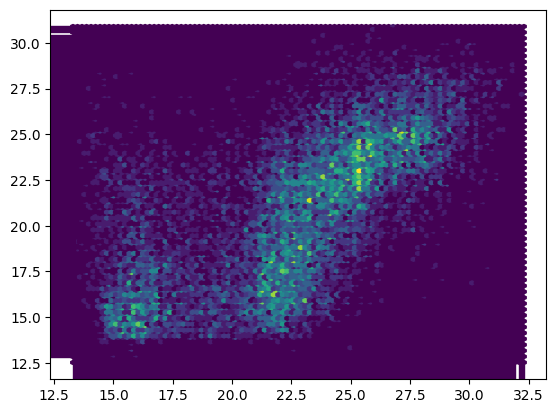

In [299]:
from sklearn.metrics import mean_squared_error

print(y_pred_KN.size)
print( np.sqrt(mean_squared_error(y_test, y_pred_KN)) )
plt.hexbin(y_test, y_pred_KN, gridsize = 100, marginals = True)


### _4.B, 4.C DISEÑO EXPERIMENTACIÓN Y ENTRENAMIENTO DE MODELOS_ ###

5. Se crea un pipeline para encapsular todo el proceso de modelamiento, entrenamiento, selección de hiperparámetros y validación cruzada.
   Se inicia con el método de vecinos más cercanos buscando los mejores valores para los siguientes hiperparámetros:
  
  - _n_neighbors:_ Validación del mejor número de vecinos entre 2 y 20 con salto de 2.
  - _weights:_ Validación del mejor peso entre uniforme y distancia.

In [300]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline_1 = Pipeline([
    ('KN', KNeighborsRegressor())
])

parameters_1 = {
    'KN__n_neighbors' : [i for i in range(2, 20, 2) ],
    'KN__weights'     : ['uniform', 'distance']
}

grid_search_1 = GridSearchCV(pipeline_1, parameters_1, cv=3,
                            verbose = 3)

In [301]:
grid_search_1.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END KN__n_neighbors=2, KN__weights=uniform;, score=0.826 total time=   1.7s
[CV 2/3] END KN__n_neighbors=2, KN__weights=uniform;, score=0.787 total time=   4.1s
[CV 3/3] END KN__n_neighbors=2, KN__weights=uniform;, score=0.528 total time=   2.1s
[CV 1/3] END KN__n_neighbors=2, KN__weights=distance;, score=0.826 total time=   1.6s
[CV 2/3] END KN__n_neighbors=2, KN__weights=distance;, score=0.787 total time=   2.6s
[CV 3/3] END KN__n_neighbors=2, KN__weights=distance;, score=0.527 total time=   2.1s
[CV 1/3] END KN__n_neighbors=4, KN__weights=uniform;, score=0.865 total time=   2.3s
[CV 2/3] END KN__n_neighbors=4, KN__weights=uniform;, score=0.820 total time=   4.2s
[CV 3/3] END KN__n_neighbors=4, KN__weights=uniform;, score=0.568 total time=   2.5s
[CV 1/3] END KN__n_neighbors=4, KN__weights=distance;, score=0.864 total time=   2.0s
[CV 2/3] END KN__n_neighbors=4, KN__weights=distance;, score=0.820 total time=   3.2s

GridSearchCV(cv=3, estimator=Pipeline(steps=[('KN', KNeighborsRegressor())]),
             param_grid={'KN__n_neighbors': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'KN__weights': ['uniform', 'distance']},
             verbose=3)

Se observa una correlación mayor al 78%, lo cual indica que hay un buen comportamiento del modelo, esto se corrobora con la gráfica de correlación.

In [302]:
print(f"Mejor puntuación: {grid_search_1.best_score_}")
print("Mejor valores parámetros:")

best_parameters_1 = grid_search_1.best_params_
for param in sorted(parameters_1.keys()):
    print(f"\t{param}: {best_parameters_1[param]}")

Mejor puntuación: 0.7811329775012483
Mejor valores parámetros:
	KN__n_neighbors: 18
	KN__weights: distance


3.444319095639297


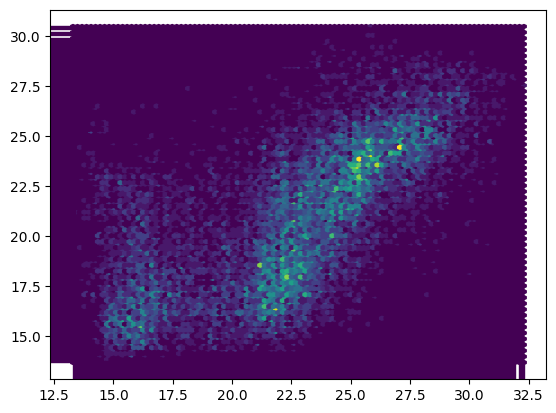

In [303]:
y_pred_1 = grid_search_1.predict(X_test)
print( np.sqrt(mean_squared_error(y_test, y_pred_1)) )
plt.hexbin(y_test, y_pred_1, gridsize = 100, marginals = True)

6. Se crea un nuevo pipeline para la evaluación de random forest buscando ajustar los siguientes hiperparámetros:

-_n_estimators:_  se prueban varias cantidades de arboles.

-_max_features:_ Se ajusta el porcentaje de características a tomar en cada split.

In [304]:
from sklearn.ensemble import RandomForestRegressor

pipeline_2 = Pipeline([
    ('RF', RandomForestRegressor())
])

parameters_2 = {
    'RF__n_estimators' : [i for i in range(2, 20, 2) ],
    'RF__max_features' : [i/5 for i in range(2, 5, 1) ]
}

grid_search_2 = GridSearchCV(pipeline_2, parameters_2, cv=3,
                            verbose = 3)

grid_search_2.fit(X_train, y_train)



Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END RF__max_features=0.4, RF__n_estimators=2;, score=0.824 total time=   0.5s
[CV 2/3] END RF__max_features=0.4, RF__n_estimators=2;, score=0.793 total time=   0.5s
[CV 3/3] END RF__max_features=0.4, RF__n_estimators=2;, score=0.512 total time=   0.5s
[CV 1/3] END RF__max_features=0.4, RF__n_estimators=4;, score=0.878 total time=   1.1s
[CV 2/3] END RF__max_features=0.4, RF__n_estimators=4;, score=0.838 total time=   0.9s
[CV 3/3] END RF__max_features=0.4, RF__n_estimators=4;, score=0.589 total time=   0.7s
[CV 1/3] END RF__max_features=0.4, RF__n_estimators=6;, score=0.885 total time=   1.1s
[CV 2/3] END RF__max_features=0.4, RF__n_estimators=6;, score=0.850 total time=   1.0s
[CV 3/3] END RF__max_features=0.4, RF__n_estimators=6;, score=0.589 total time=   1.2s
[CV 1/3] END RF__max_features=0.4, RF__n_estimators=8;, score=0.883 total time=   3.0s
[CV 2/3] END RF__max_features=0.4, RF__n_estimators=8;, score=0.858 t

GridSearchCV(cv=3, estimator=Pipeline(steps=[('RF', RandomForestRegressor())]),
             param_grid={'RF__max_features': [0.4, 0.6, 0.8],
                         'RF__n_estimators': [2, 4, 6, 8, 10, 12, 14, 16, 18]},
             verbose=3)

El modelo ya ha superado la correlación del 79%, generando una leve mejoría respecto al modelo de vecinos más cercanos, esto se ha
logrado haciendo uso de 16 árboles y tomando el 60% de las características en cada split.

In [305]:
print(f"Mejor puntuación: {grid_search_2.best_score_}")
print("Mejor valores parámetros:")

best_parameters_2 = grid_search_2.best_params_
for param in sorted(parameters_2.keys()):
    print(f"\t{param}: {best_parameters_2[param]}")

Mejor puntuación: 0.7922207244419054
Mejor valores parámetros:
	RF__max_features: 0.4
	RF__n_estimators: 16


EL MSE en los datos de prueba demuestra que en efecto este modelo presenta un  comportamiento similar respecto a posibles errores grandes comparado el modelo de vecinos más cercanos.

3.66723939237017


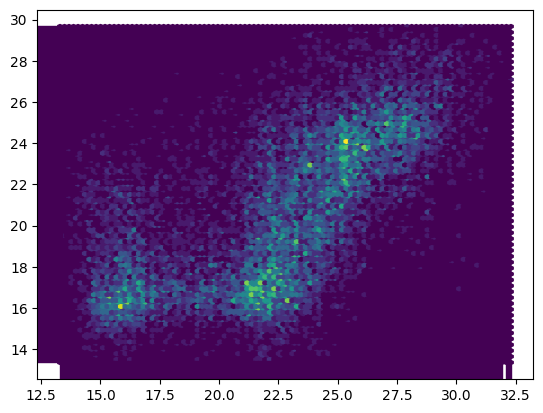

In [306]:
y_pred_2 = grid_search_2.predict(X_test)
print( np.sqrt(mean_squared_error(y_test, y_pred_2)) )
plt.hexbin(y_test, y_pred_2, gridsize = 100, marginals = True )

7. Por último se desarrolla el pipeline para redes neuronales, en este caso se evaluaron múltiples hiperparámetros:  

    El objetivo era encontrar el solver y los métodos de activación más adecuados para este sistema, se encuentra que el solver _Adam_ funciona muy bien para este caso, en cambio, _sgd_ lo hace de forma bastante regular

In [307]:
from sklearn.neural_network import MLPRegressor

pipeline_3 = Pipeline([
    ('MLP', MLPRegressor())
])

parameters_3 = {
    'MLP__hidden_layer_sizes' : [60, 90, 120 ],
    'MLP__activation' : [ 'logistic', 'relu' ],
    'MLP__solver' : [ 'adam' ],
    'MLP__max_iter' : [ 200 ],
    'MLP__random_state' : [ 1 ]
}

grid_search_3 = GridSearchCV(pipeline_3, parameters_3, cv=3,
                            verbose = 3)

grid_search_3.fit(X_train, y_train)



Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END MLP__activation=logistic, MLP__hidden_layer_sizes=60, MLP__max_iter=200, MLP__random_state=1, MLP__solver=adam;, score=0.928 total time= 1.4min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END MLP__activation=logistic, MLP__hidden_layer_sizes=60, MLP__max_iter=200, MLP__random_state=1, MLP__solver=adam;, score=0.877 total time= 1.3min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END MLP__activation=logistic, MLP__hidden_layer_sizes=60, MLP__max_iter=200, MLP__random_state=1, MLP__solver=adam;, score=0.614 total time= 1.4min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END MLP__activation=logistic, MLP__hidden_layer_sizes=90, MLP__max_iter=200, MLP__random_state=1, MLP__solver=adam;, score=0.927 total time= 1.7min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END MLP__activation=logistic, MLP__hidden_layer_sizes=90, MLP__max_iter=200, MLP__random_state=1, MLP__solver=adam;, score=0.877 total time= 1.7min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END MLP__activation=logistic, MLP__hidden_layer_sizes=90, MLP__max_iter=200, MLP__random_state=1, MLP__solver=adam;, score=0.612 total time= 1.7min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END MLP__activation=logistic, MLP__hidden_layer_sizes=120, MLP__max_iter=200, MLP__random_state=1, MLP__solver=adam;, score=0.930 total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END MLP__activation=logistic, MLP__hidden_layer_sizes=120, MLP__max_iter=200, MLP__random_state=1, MLP__solver=adam;, score=0.878 total time= 2.1min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END MLP__activation=logistic, MLP__hidden_layer_sizes=120, MLP__max_iter=200, MLP__random_state=1, MLP__solver=adam;, score=0.616 total time= 2.1min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END MLP__activation=relu, MLP__hidden_layer_sizes=60, MLP__max_iter=200, MLP__random_state=1, MLP__solver=adam;, score=0.919 total time= 1.7min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END MLP__activation=relu, MLP__hidden_layer_sizes=60, MLP__max_iter=200, MLP__random_state=1, MLP__solver=adam;, score=0.878 total time= 1.7min
[CV 3/3] END MLP__activation=relu, MLP__hidden_layer_sizes=60, MLP__max_iter=200, MLP__random_state=1, MLP__solver=adam;, score=0.610 total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END MLP__activation=relu, MLP__hidden_layer_sizes=90, MLP__max_iter=200, MLP__random_state=1, MLP__solver=adam;, score=0.915 total time= 2.5min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END MLP__activation=relu, MLP__hidden_layer_sizes=90, MLP__max_iter=200, MLP__random_state=1, MLP__solver=adam;, score=0.877 total time= 2.3min
[CV 3/3] END MLP__activation=relu, MLP__hidden_layer_sizes=90, MLP__max_iter=200, MLP__random_state=1, MLP__solver=adam;, score=0.621 total time= 1.9min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END MLP__activation=relu, MLP__hidden_layer_sizes=120, MLP__max_iter=200, MLP__random_state=1, MLP__solver=adam;, score=0.914 total time= 3.1min
[CV 2/3] END MLP__activation=relu, MLP__hidden_layer_sizes=120, MLP__max_iter=200, MLP__random_state=1, MLP__solver=adam;, score=0.878 total time= 3.0min
[CV 3/3] END MLP__activation=relu, MLP__hidden_layer_sizes=120, MLP__max_iter=200, MLP__random_state=1, MLP__solver=adam;, score=0.614 total time= 2.7min


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=3, estimator=Pipeline(steps=[('MLP', MLPRegressor())]),
             param_grid={'MLP__activation': ['logistic', 'relu'],
                         'MLP__hidden_layer_sizes': [60, 90, 120],
                         'MLP__max_iter': [200], 'MLP__random_state': [1],
                         'MLP__solver': ['adam']},
             verbose=3)

El modelo de redes neuronales obtiene el mejor comportamiento por una diferencia pequeña, pero ya logra entrar sobre el 80% en puntuación, por lo cual se selecciona.

In [309]:
print(f"Mejor puntuación: {grid_search_3.best_score_}")
print("Mejor valores parámetros:")

best_parameters_3 = grid_search_3.best_params_
for param in sorted(parameters_3.keys()):
    print(f"\t{param}: {best_parameters_3[param]}")

Mejor puntuación: 0.8079430286158699
Mejor valores parámetros:
	MLP__activation: logistic
	MLP__hidden_layer_sizes: 120
	MLP__max_iter: 200
	MLP__random_state: 1
	MLP__solver: adam


5.075858963049535


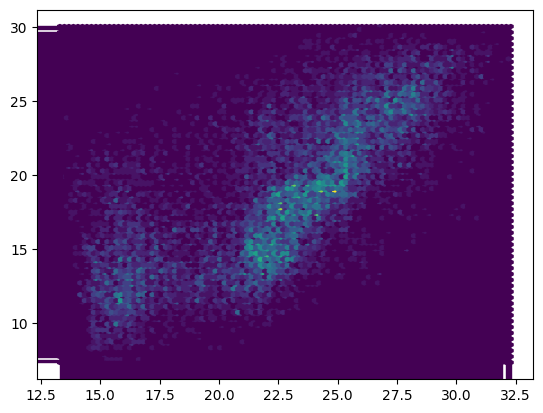

In [310]:
y_pred_3 = grid_search_3.predict(X_test)
print( np.sqrt(mean_squared_error(y_test, y_pred_3)) )
plt.hexbin(y_test, y_pred_3, gridsize = 100, marginals = True)

## CONCLUSIONES ##

1. El modelo seleccionado para este sistema es redes neuronales de características tomadas en cada split, se obtiene un score de R2 mayor al 80%.

2. Para este ejercicio se comprueba definitivamente que para las mismas temperaturas y cargas se encuentran diferentes valores de temperatura de salida del Gas Cooler, tal como se esperaba al inicio del proyecto.

3. Debido a que es posible que se hayan modificado parámetros de control en el rango de tiempo de la toma de datos, debe verificarse si esto podría alterar las predicciones que haga el modelo y si este debe ajustarse dinamicamente para permitir al usuario ajustar su sistema.

4. El preprocesamiento permitió comprender además de la importancia de cada variable al modelo, problemas y preexistencias del sistema que deben
ser corregidas para predecir luego con un sistema operando correctamente.

5. Se plantea avanzar con el proyecto para refinar el valor o tiempo entre los eventos de cambio de temperatura para determinar las frecuencias óptimas de mtto en este sistema en particular.